# Neural Style Transfer with Keras


## Outline:

1.Setup

2.Visuialize Input

3.Manipulate data

4.Score Metric

5.plement the Neural Network class

6.ain the Neural Network

7.lidate the Neural Network

8.ke Test Prediction

9.bmit

Reference:
U-Net: Convolutional Networks for Biomedical Image Segmentation

## 1. Set up

In [1]:
#Import and configure model
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as k

C:\Users\eric11eca\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Visuialize Input

In [2]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [3]:
# set up image path
content_path = 'images/content/amber.jpg'
style_path = 'images/style/mosaic.jpg'

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
    img = kp_image.img_to_array(img)
  
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    
    plt.imshow(out)

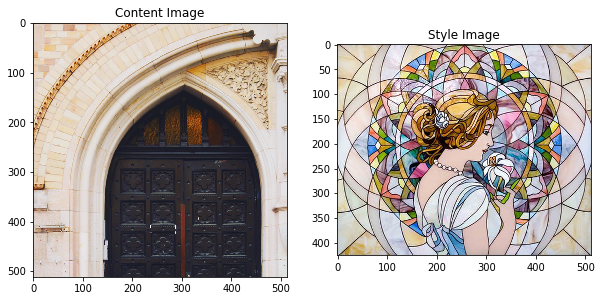

In [5]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Prepare the Data

In [6]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [7]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the Network Model

In [9]:
def load_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return models.Model(vgg.input, model_outputs)

## Define and Creat Loss Function

### Content Loss

In [10]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

### Style Loss

In [11]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1,channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

## Apply Style Transfer

### Gradient Descent

In [12]:
def get_feature_representations(model, content_path, style_path):
    # load and pre-processing images
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [13]:
def loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    weight_pre_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_pre_style_layer * get_style_loss(comb_style[0], target_style)
        
    weight_pre_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_pre_content_layer* get_content_loss(comb_content[0], target_content)  
        
    style_score *= style_weight
    content_score *= content_weight
    
    loss = style_score + content_score
    return loss, style_score, content_score

In [14]:
def get_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [15]:
import IPython.display

def run_transfer(content_path, style_path, 
                 num_iterations=1000, 
                 content_weight=1e3, 
                 style_weight=1e-2):
    model = load_model()
    for layers in model.layers:
        layers.trainable = False
        
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    count = 1
    
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)

    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means  
    
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = get_grads(cfg)
        loss, style_score, content_score = all_loss
        optimizer.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
        
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())
        
        if i % display_interval== 0:
            start_time = time.time()
            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
            
    return best_img, best_loss 

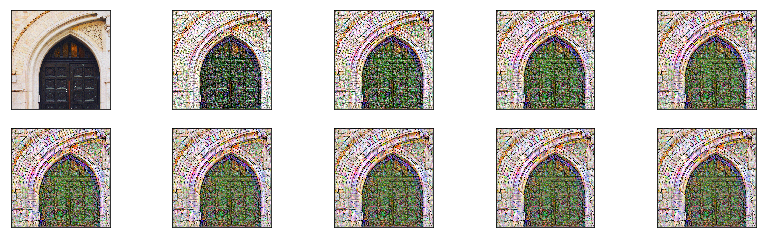

In [16]:
best_img, best_loss = run_transfer(content_path, style_path,
                                   num_iterations=1000)

In [ ]:
s = Image.fromarray(best_img)
s.save('transferd5.jpg')

In [ ]:
def visualize_result(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10,5))
    content = load_img(content_path)
    style = load_img(style_path)
    
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    
    if show_large_final:
        plt.figure(figsize=(10,10))
        plt.imshow(best_img)
        plt.title('Transfered Image')
        plt.show()

In [ ]:
visualize_result(best_img, content_path, style_path)

In [ ]:
content_path = 'fuchunjiang1.jpg'
style_path = 'The_Great_Wave_off_the_Coast_of_Kanagawa.jpg'
best_img, best_loss = run_transfer(content_path, style_path,
                                   num_iterations=1000)
visualize_result(best_img, content_path, style_path)

In [ ]:
j = Image.fromarray(best_img)
j.save('countrywomen.jpg')

In [ ]:
content_path = 'xihuhehua.jpg'
style_path = 'water lilies.jpg'
best_img, best_loss = run_transfer(content_path, style_path,
                                   num_iterations=1000)
visualize_result(best_img, content_path, style_path)

In [ ]:
d = Image.fromarray(best_img)
d.save('street2.jpg')

In [ ]:
content_path = 'xihuhehua.jpg'
style_path = 'water lilies.jpg'
best_img, best_loss = run_transfer(content_path, style_path,
                                   num_iterations=1000)
visualize_result(best_img, content_path, style_path)